In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import uniform
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import joblib

In [ ]:
df = pd.read_csv('pasteurizer.csv')

In [ ]:
# 데이터셋 전처리
df = df.dropna()
df = df.drop(df.MIXA_PASTEUR_STATE[df.MIXA_PASTEUR_STATE > 1].index)
df = df.drop(df.MIXB_PASTEUR_STATE[df.MIXB_PASTEUR_STATE > 1].index)
df = df.drop(df.MIXB_PASTEUR_TEMP[df.MIXB_PASTEUR_TEMP > 1000].index)
df.INSP = df.INSP.replace('OK',1).replace('NG',0).astype(int)
df = df.reset_index(drop=True)
df = df.drop('STD_DT',axis=1)

In [ ]:
train = df[df.index < 6567]
test = df[df.index >= 6567]
target = 'INSP'

In [ ]:
train

,MIXA_PASTEUR_STATE,MIXB_PASTEUR_STATE,MIXA_PASTEUR_TEMP,MIXB_PASTEUR_TEMP,INSP
0,1.0,1.0,551.0,524.0,1
1,1.0,1.0,584.0,536.0,1
2,1.0,1.0,584.0,536.0,1
3,1.0,1.0,585.0,536.0,1
4,1.0,1.0,585.0,536.0,1
...,...,...,...,...,...
6562,1.0,1.0,540.0,556.0,1
6563,1.0,1.0,527.0,560.0,1
6564,1.0,1.0,564.0,518.0,1
6565,1.0,1.0,570.0,514.0,1


In [ ]:
X_train, y_train = train.drop(columns=target), train[target]
X_test, y_test = test.drop(columns=target), test[target]

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        learning_rate=0.01,
        scale_pos_weight=1,
        max_depth = 10,
        use_label_encoder=False,
    ),
)

In [ ]:
params = {
    "simpleimputer__strategy": ["median", "mean"],
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ),
}

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring="f1",
    n_iter=100,
    cv=5,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.954 total time=   0.5s
[CV 2/5] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.920 total time=   0.4s
[CV 3/5] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.920 total time=   0.4s
[CV 4/5] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.920 total time=   0.4s
[CV 5/5] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('xgbclassifier',
                                              XGBClassifier(eval_metric='error',
                                                            learning_rate=0.01,
                                                            max_depth=10,
                                                            n_estimators=200,
                                                            n_jobs=-1,
                                                            random_state=42,
                                                            scale_pos_weight=220,
                                                            use_label_encoder=False))]),
       

In [ ]:
randomized_search.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['STD_DT'],
                                mapping=[{'col': 'STD_DT',
                                          'data_type': dtype('O'),
                                          'mapping': 2020-03-04 6:00        1
2020-03-04 6:30        2
2020-03-04 7:00        3
2020-03-04 7:30        4
2020-03-04 8:00        5
                    ... 
2020-07-18 23:30    6564
2020-07-19 0:00     6565
2020-07-19 0:30     6566
2020-07-19 1:00     6567
NaN                   -2
Length: 6568, dtype: int64}])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(colsample_bytree=0.8982714934301164,
                               eval_metric='error', learning_rate=0.01,
                               max_depth=6, min_child_weight=8,
                               n_estimators=200, n_jobs=-1, random_state=42,
                               scale_pos_weigh

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(eval_metric='error', learning_rate=0.01,
                               max_depth=10, n_estimators=200, n_jobs=-1,
                               random_state=42, use_label_encoder=False))])

# **모델 검증**

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.95      0.53       445
           1       0.99      0.70      0.82      2371

    accuracy                           0.74      2816
   macro avg       0.68      0.82      0.68      2816
weighted avg       0.89      0.74      0.77      2816



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


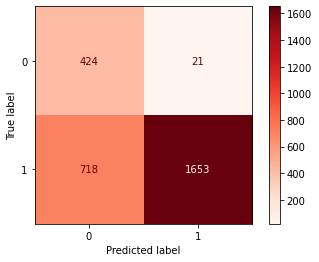

In [ ]:
plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Reds)

In [ ]:
joblib.dump(pipe, './knn_model.pkl')

['./knn_model.pkl']